In [1]:
import pandas as pd
import numpy as np
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime



In [2]:
ari_incidence = pd.read_csv("latest-ARI_incidence.csv",sep=',')
ili_incidence = pd.read_csv("latest-ILI_incidenc    e.csv",sep=',')

In [3]:
ari_incidence.head()

,location,truth_date,year_week,value
0,BE,2024-10-13,2024-W41,1384.1
1,BE,2024-10-06,2024-W40,1182.0
2,BE,2024-09-29,2024-W39,1216.6
3,BE,2024-09-22,2024-W38,993.0
4,BE,2024-09-15,2024-W37,927.0


In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [5]:
url = "https://archive-api.open-meteo.com/v1/archive"

In [6]:
#capitals ARI
params_ari = {
    "latitude": [50.8503, 42.6977, 50.0755, 52.52, 59.437, 40.4168, 48.8566, 47.4979, 54.6872, 49.8153, 56.9496, 44.4268, 46.0569],
    "longitude": [4.3517, 23.3219, 14.4378, 13.405, 24.7536, -3.7038, 2.3522, 19.0402, 25.2797, 6.1296, 24.1052, 26.1025, 14.5058],
    "hourly": "relative_humidity_2m",
    "timezone": "auto",
    "start_date": "2014-10-05",
    "end_date": "2024-10-13"
}
country_names_ari = [
    "BE", "BG", "CZ", "DE", "EE",
    "ES", "FR", "HU", "LT", "LU",
    "LV", "RO", "SI"
]



In [7]:
ari_incidence = ari_incidence[ari_incidence['location'].isin(country_names_ari)]
ari_incidence.groupby('location').count()

,truth_date,year_week,value
location,,,
BE,524,524,524
BG,514,514,514
CZ,523,523,523
DE,524,524,524
EE,506,506,506
ES,158,158,158
FR,167,167,167
HU,66,66,66
LT,508,508,508


In [8]:

responses = openmeteo.weather_api(url, params=params_ari) 
all_data_ari = []

# Loop through all responses
for country, response in zip(country_names_ari, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the hourly data
    hourly = response.Hourly()
    hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()

    # Create a DataFrame for the current location
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "relative_humidity_2m": hourly_relative_humidity_2m,
        "country": [country] * len(hourly_relative_humidity_2m)  # Add country column
    }

    all_data_ari.append(pd.DataFrame(data=hourly_data))

data_ari_humidity = pd.concat(all_data_ari, ignore_index=True)


# Optionally save to CSV
data_ari_humidity.to_csv("data_humidity_ari .csv", index=False)


In [9]:
data_ari_humidity.groupby('country').count()

,date,relative_humidity_2m
country,,
BE,87888,87888
BG,87888,87888
CZ,87888,87888
DE,87888,87888
EE,87888,87888
ES,87888,87888
FR,87888,87888
HU,87888,87888
LT,87888,87888


In [10]:
params_ari_temp = {
 	"latitude": [50.8503, 42.6977, 50.0755, 52.52, 59.437, 40.4168, 48.8566, 47.4979, 54.6872, 49.8153, 56.9496, 44.4268, 46.0569],
    "longitude": [4.3517, 23.3219, 14.4378, 13.405, 24.7536, -3.7038, 2.3522, 19.0402, 25.2797, 6.1296, 24.1052, 26.1025, 14.5058],
	"daily": ["temperature_2m_max", "temperature_2m_min"],
	"timezone": "auto",
	"start_date": "2014-10-05",
	"end_date": "2024-10-13"
}

In [11]:

responses = openmeteo.weather_api(url, params=params_ari_temp) 
all_data_temp_ari = []

# Loop through all responses
for country, response in zip(country_names_ari, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the daily data
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()

    # Create a DataFrame for the current location
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "temperature_2m_max": daily_temperature_2m_max,
        "temperature_2m_min": daily_temperature_2m_min,
        "country": [country] * len(daily_temperature_2m_max)  # Add country column
    }

    # Convert to DataFrame and append to the list
    all_data_temp_ari.append(pd.DataFrame(data=daily_data))

data_temp_ari = pd.concat(all_data_temp_ari, ignore_index=True)

data_temp_ari.to_csv("data_temp_ari.csv", index=False)


In [12]:
data_temp_ari.head()

,date,temperature_2m_max,temperature_2m_min,country
0,2014-10-04 23:00:00+00:00,13.586500,11.336500,BE
1,2014-10-05 23:00:00+00:00,13.936501,12.186501,BE
2,2014-10-06 23:00:00+00:00,15.236501,9.836500,BE
3,2014-10-07 23:00:00+00:00,16.886499,9.586500,BE
4,2014-10-08 23:00:00+00:00,17.936499,12.886500,BE


In [13]:
#params for ili humidity
params_ili = {
    "latitude": [
        47.5162, 50.8503, 50.0755, 55.6761, 59.437,
        48.8566, 37.9838, 45.815, 47.4979, 53.3498,
        54.6872, 49.8153, 56.9496, 35.8997, 52.3676,
        59.9139, 52.2297, 44.4268, 46.0569
    ],
    "longitude": [
        14.5501, 4.3517, 14.4378, 12.5683, 24.7536,
        2.3522, 23.7275, 15.9819, 19.0402, -6.2603,
        25.2797, 6.1296, 24.1052, 14.5146, 4.9041,
        10.7522, 21.0122, 26.1025, 14.5058
    ],
    "hourly": "relative_humidity_2m",
    "timezone": "auto",
    "start_date": "2014-10-05",
    "end_date": "2024-10-13"
}
country_names_ili = [
    "AT","BE","CZ","DK",
    "EE","FR","GR","HR",
    "HU","IE","LT","LU",
    "LV","MT","NL","NO",
    "PL","RO","SI"
]


In [14]:
ili_incidence = ili_incidence[ili_incidence['location'].isin(country_names_ili)]
ili_incidence.groupby('location').count()

,truth_date,year_week,value
location,,,
AT,262,262,262
BE,524,524,524
CZ,523,523,523
DK,406,406,406
EE,514,514,514
FR,349,349,349
GR,514,514,514
HR,326,326,326
HU,324,324,324


In [15]:

responses = openmeteo.weather_api(url, params=params_ili) 
all_data_ili = []

for country, response in zip(country_names_ili, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the hourly data
    hourly = response.Hourly()
    hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()

    # Create a DataFrame for the current location
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "relative_humidity_2m": hourly_relative_humidity_2m,
        "country": [country] * len(hourly_relative_humidity_2m)  # Add country column
    }

    # Convert to DataFrame and append to the list
    all_data_ili.append(pd.DataFrame(data=hourly_data))

data_ili_humidity = pd.concat(all_data_ili, ignore_index=True)

data_ili_humidity.to_csv("data_humidity_ili .csv", index=False)


In [16]:
data_ili_humidity.head()

,date,relative_humidity_2m,country
0,2014-10-04 23:00:00+00:00,94.026505,AT
1,2014-10-05 00:00:00+00:00,95.318687,AT
2,2014-10-05 01:00:00+00:00,96.300850,AT
3,2014-10-05 02:00:00+00:00,96.961899,AT
4,2014-10-05 03:00:00+00:00,97.294327,AT


In [17]:
#params for temp ili
params_ili_temp = {
    "latitude": [
        47.5162, 50.8503, 50.0755, 55.6761, 59.437,
        48.8566, 37.9838, 45.815, 47.4979, 53.3498,
        54.6872, 49.8153, 56.9496, 35.8997, 52.3676,
        59.9139, 52.2297, 44.4268, 46.0569
    ],
    "longitude": [
        14.5501, 4.3517, 14.4378, 12.5683, 24.7536,
        2.3522, 23.7275, 15.9819, 19.0402, -6.2603,
        25.2797, 6.1296, 24.1052, 14.5146, 4.9041,
        10.7522, 21.0122, 26.1025, 14.5058
    ],
	"daily": ["temperature_2m_max", "temperature_2m_min"],
	"timezone": "auto",
	"start_date": "2014-10-05",
	"end_date": "2024-10-13"
}

In [18]:

responses = openmeteo.weather_api(url, params=params_ili_temp)  
all_data_temp_ili = []

for country, response in zip(country_names_ili, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the daily data
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()

    # Create a DataFrame for the current location
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "temperature_2m_max": daily_temperature_2m_max,
        "temperature_2m_min": daily_temperature_2m_min,
        "country": [country] * len(daily_temperature_2m_max)  # Add country column
    }

    # Convert to DataFrame and append to the list
    all_data_temp_ili.append(pd.DataFrame(data=daily_data))

# Combine all DataFrames into one
data_temp_ili = pd.concat(all_data_temp_ili, ignore_index=True)

# Optionally save to CSV
data_temp_ili.to_csv("data_temp_ili.csv", index=False)


In [19]:
data_temp_ili.nunique()

date                  10986
temperature_2m_max    18850
temperature_2m_min    16501
country                  19
dtype: int64

In [20]:
data_ari_humidity.dtypes

date                    datetime64[ns, UTC]
relative_humidity_2m                float32
country                              object
dtype: object

In [21]:
data_ari_humidity['Fecha'] = data_ari_humidity['date'].dt.strftime('%Y-%m-%d')
data_ili_humidity['Fecha'] = data_ili_humidity['date'].dt.strftime('%Y-%m-%d')
data_temp_ari['Fecha'] = data_temp_ari['date'].dt.strftime('%Y-%m-%d')
data_temp_ili['Fecha'] = data_temp_ili['date'].dt.strftime('%Y-%m-%d')

In [22]:
data_ari_humidity.head()

,date,relative_humidity_2m,country,Fecha
0,2014-10-04 23:00:00+00:00,93.623543,BE,2014-10-04
1,2014-10-05 00:00:00+00:00,93.616280,BE,2014-10-05
2,2014-10-05 01:00:00+00:00,92.990158,BE,2014-10-05
3,2014-10-05 02:00:00+00:00,92.056679,BE,2014-10-05
4,2014-10-05 03:00:00+00:00,90.515244,BE,2014-10-05


In [23]:
data_ari_humidity.columns

Index(['date', 'relative_humidity_2m', 'country', 'Fecha'], dtype='object')

In [24]:
#mean by day for humidity
data_ili_hum_by_day = data_ili_humidity[['relative_humidity_2m', 'country', 'Fecha']].groupby(['country', 'Fecha'])['relative_humidity_2m'].mean().reset_index()
data_ari_hum_by_day = data_ari_humidity[['relative_humidity_2m', 'country', 'Fecha']].groupby(['country','Fecha'])['relative_humidity_2m'].mean().reset_index()


In [25]:
data_ari_hum_by_day['Fecha'] = pd.to_datetime(data_ari_hum_by_day['Fecha'])
data_ili_hum_by_day['Fecha'] = pd.to_datetime(data_ili_hum_by_day['Fecha'])

In [26]:
ari_incidence.head()

,location,truth_date,year_week,value
0,BE,2024-10-13,2024-W41,1384.1
1,BE,2024-10-06,2024-W40,1182.0
2,BE,2024-09-29,2024-W39,1216.6
3,BE,2024-09-22,2024-W38,993.0
4,BE,2024-09-15,2024-W37,927.0


In [27]:
data_ari_hum_by_day.dtypes

country                         object
Fecha                   datetime64[ns]
relative_humidity_2m           float32
dtype: object

In [28]:
data_temp_ili.dtypes

date                  datetime64[ns, UTC]
temperature_2m_max                float32
temperature_2m_min                float32
country                            object
Fecha                              object
dtype: object

In [29]:
#add variable Week of years
data_ari_hum_by_day['week_of_year'] = data_ari_hum_by_day['Fecha'].dt.isocalendar().week.astype('str').str.zfill(2)

data_ari_hum_by_day['year'] = data_ari_hum_by_day['Fecha'].dt.strftime('%Y')
data_ari_hum_by_day['year_week'] = data_ari_hum_by_day['year'] + '-W'+data_ari_hum_by_day['week_of_year']

data_ili_hum_by_day['week_of_year'] = data_ili_hum_by_day['Fecha'].dt.isocalendar().week.astype('str').str.zfill(2)
data_ili_hum_by_day['year'] = data_ili_hum_by_day['Fecha'].dt.strftime('%Y')
data_ili_hum_by_day['year_week'] = data_ili_hum_by_day['year'] + '-W'+data_ili_hum_by_day['week_of_year']

data_temp_ari['week_of_year'] = pd.to_datetime(data_temp_ari['Fecha']).dt.isocalendar().week.astype('str').str.zfill(2)
data_temp_ari['year'] = pd.to_datetime(data_temp_ari['Fecha']).dt.strftime('%Y')
data_temp_ari['year_week'] = data_temp_ari['year'] + '-W'+data_temp_ari['week_of_year']

data_temp_ili['week_of_year'] = pd.to_datetime(data_temp_ili['Fecha']).dt.isocalendar().week.astype('str').str.zfill(2)
data_temp_ili['year'] = pd.to_datetime(data_temp_ili['Fecha']).dt.strftime('%Y')
data_temp_ili['year_week'] = data_temp_ili['year'] + '-W'+data_temp_ili['week_of_year']


In [30]:
data_ili_hum_by_day.head()

,country,Fecha,relative_humidity_2m,week_of_year,year,year_week
0,AT,2014-10-04,94.026505,40,2014,2014-W40
1,AT,2014-10-05,87.661407,40,2014,2014-W40
2,AT,2014-10-06,81.162392,41,2014,2014-W41
3,AT,2014-10-07,78.742058,41,2014,2014-W41
4,AT,2014-10-08,85.323982,41,2014,2014-W41


In [31]:
data_temp_ari.to_csv("dat.csv")

In [32]:
a = data_temp_ari[data_temp_ari['Fecha']>='2015-01-01']
b= a[a['Fecha']<='2016-01-30']
b[b['year_week']=='2015-W01']

,date,temperature_2m_max,temperature_2m_min,country,Fecha,week_of_year,year,year_week
89,2015-01-01 23:00:00+00:00,9.8365,2.536500,BE,2015-01-01,01,2015,2015-W01
90,2015-01-02 23:00:00+00:00,3.4365,1.686500,BE,2015-01-02,01,2015,2015-W01
91,2015-01-03 23:00:00+00:00,5.6365,-0.113500,BE,2015-01-03,01,2015,2015-W01
92,2015-01-04 23:00:00+00:00,3.5865,-0.813500,BE,2015-01-04,01,2015,2015-W01
3751,2015-01-01 22:00:00+00:00,-2.9695,-17.969501,BG,2015-01-01,01,2015,2015-W01
3752,2015-01-02 22:00:00+00:00,1.5305,-11.119500,BG,2015-01-02,01,2015,2015-W01
3753,2015-01-03 22:00:00+00:00,3.9805,-5.269500,BG,2015-01-03,01,2015,2015-W01
3754,2015-01-04 22:00:00+00:00,-1.7195,-8.419499,BG,2015-01-04,01,2015,2015-W01
7413,2015-01-01 23:00:00+00:00,4.2885,1.038500,CZ,2015-01-01,01,2015,2015-W01
7414,2015-01-02 23:00:00+00:00,3.0885,0.488500,CZ,2015-01-02,01,2015,2015-W01


In [33]:
data_temp_ari.isna().sum()/data_temp_ari.shape[0]

date                  0.0
temperature_2m_max    0.0
temperature_2m_min    0.0
country               0.0
Fecha                 0.0
week_of_year          0.0
year                  0.0
year_week             0.0
dtype: float64

In [34]:
"""data_temp_ari['iso_year'] = pd.to_datetime(data_temp_ari['Fecha']).dt.isocalendar().year
data_temp_ari['iso_week'] = pd.to_datetime(data_temp_ari['Fecha']).dt.isocalendar().week
data_temp_ari[data_temp_ari['iso_week']==53]"""

"data_temp_ari['iso_year'] = pd.to_datetime(data_temp_ari['Fecha']).dt.isocalendar().year\ndata_temp_ari['iso_week'] = pd.to_datetime(data_temp_ari['Fecha']).dt.isocalendar().week\ndata_temp_ari[data_temp_ari['iso_week']==53]"

In [35]:
# mean by week for humidity
data_ari_hum_by_week = data_ari_hum_by_day[['country', 'Fecha', 'relative_humidity_2m','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'relative_humidity_2m':'mean'})
data_ili_hum_by_week = data_ili_hum_by_day[['country', 'Fecha', 'relative_humidity_2m','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'relative_humidity_2m':'mean'})


In [36]:
#mean by week for temp


data_ari_temp_by_week = data_temp_ari[['temperature_2m_max', 'temperature_2m_min', 'country', 'Fecha','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'temperature_2m_max': 'mean', 'temperature_2m_min': 'mean'})

data_ili_temp_by_week = data_temp_ili[['temperature_2m_max', 'temperature_2m_min', 'country', 'Fecha','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'temperature_2m_max': 'mean', 'temperature_2m_min': 'mean'})


In [37]:
ari_incidence.columns

Index(['location', 'truth_date', 'year_week', 'value'], dtype='object')

In [38]:
data_ari_temp_by_week.head()

,country,year_week,temperature_2m_max,temperature_2m_min
0,BE,2014-W01,4.519833,0.019833
1,BE,2014-W40,13.761500,11.761500
2,BE,2014-W41,16.800785,10.586500
3,BE,2014-W42,18.193644,12.500786
4,BE,2014-W43,14.386499,9.779358


In [39]:
data_ari_hum_by_week.columns

Index(['country', 'year_week', 'relative_humidity_2m'], dtype='object')

In [40]:
print(data_ari_hum_by_week.shape)
print(ari_incidence.shape)

(6851, 3)
(5266, 4)


In [41]:
ari_incidence = ari_incidence[ari_incidence['location'].isin(country_names_ari)]
ili_incidence = ili_incidence[ili_incidence['location'].isin(country_names_ili)]

In [42]:
ari_hum = pd.merge(ari_incidence,data_ari_hum_by_week,left_on=['location','year_week'],
                   right_on = ['country','year_week'],how = 'left')
ari_hum = ari_hum.drop(columns = ['country'])

ari = pd.merge(ari_hum,data_ari_temp_by_week,left_on=['location','year_week'],
               right_on = ['country','year_week'],how='left')
ari = ari.drop(columns=['country'])
ari['truth_date'] = pd.to_datetime(ari['truth_date'])
ari.head()

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min
0,BE,2024-10-13,2024-W41,1384.1,82.940979,14.331166,9.156167
1,BE,2024-10-06,2024-W40,1182.0,80.857178,15.843072,7.521643
2,BE,2024-09-29,2024-W39,1216.6,80.408249,16.443071,10.043071
3,BE,2024-09-22,2024-W38,993.0,79.679146,22.028788,13.171644
4,BE,2024-09-15,2024-W37,927.0,80.122276,16.550215,8.150214


In [43]:
ili_hum = pd.merge(ili_incidence,data_ili_hum_by_week,left_on=['location','year_week'],
                   right_on = ['country','year_week'],how = 'left')
ili_hum = ili_hum.drop(columns = ['country'])

ili = pd.merge(ili_hum,data_ili_temp_by_week,left_on=['location','year_week'],
               right_on = ['country','year_week'],how='left')
ili = ili.drop(columns=['country'])
ili['truth_date'] = pd.to_datetime(ili['truth_date'])
ili.head()

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min
0,AT,2024-10-13,2024-W41,3214.2,82.496323,13.673167,4.914833
1,AT,2024-04-07,2024-W14,1512.6,68.046410,16.792215,3.120786
2,AT,2024-03-31,2024-W13,1629.1,73.683411,11.385071,1.506500
3,AT,2024-03-24,2024-W12,2179.8,80.152260,9.327929,-1.243500
4,AT,2024-03-17,2024-W11,1798.0,83.398750,8.677928,1.085071


In [44]:
ili.to_csv("data_ili.csv",sep=",")
ari.to_csv("data_ari.csv",sep=",")

In [45]:
#pandemic from march 2020 to may 2024
ili['covid']=np.where((ili['truth_date']>='2020-03-01') & (ili['truth_date']<='2024-05-31'),1,0)

In [46]:
ili.columns

Index(['location', 'truth_date', 'year_week', 'value', 'relative_humidity_2m',
       'temperature_2m_max', 'temperature_2m_min', 'covid'],
      dtype='object')

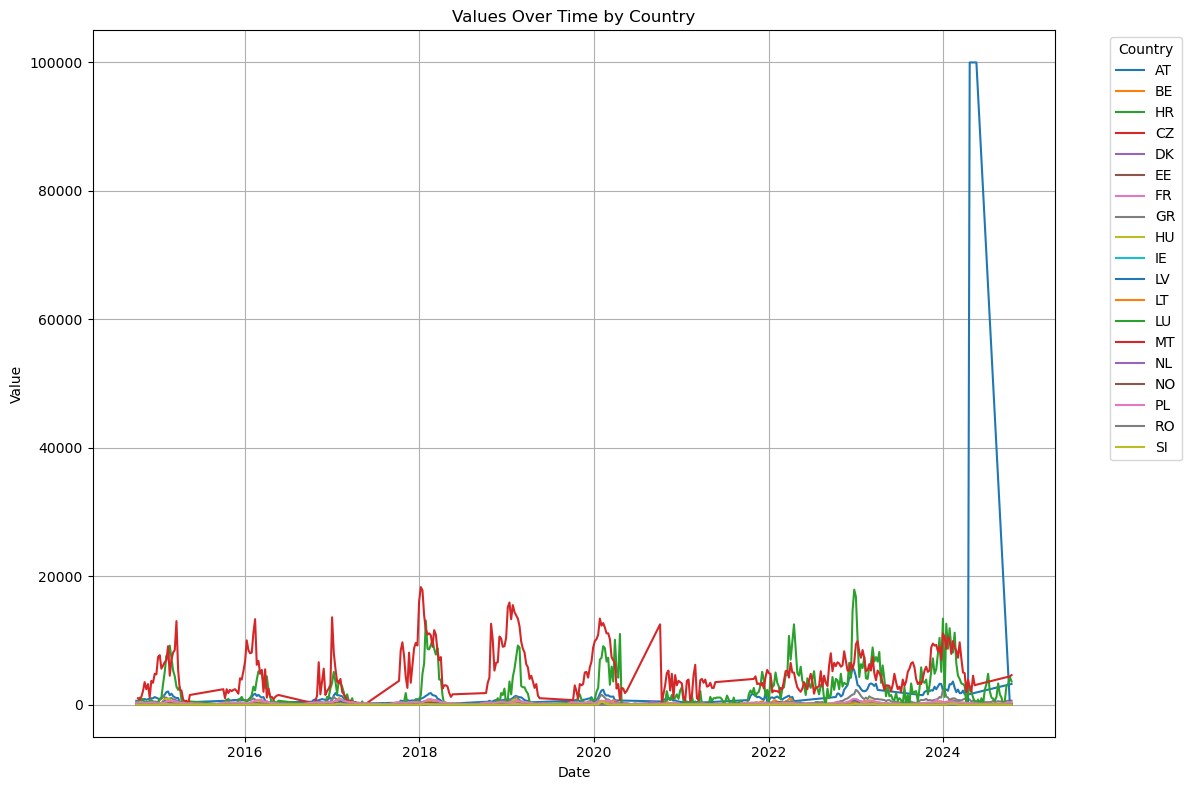

In [47]:
import matplotlib.pyplot as plt

# Group the data by country
countries = ili['location'].unique()

# Plot data for each country
plt.figure(figsize=(12, 8))
for country in countries:
    country_data = ili[ili['location'] == country]
    plt.plot(country_data['truth_date'], country_data['value'], label=country)

# Customize the plot
plt.title('Values Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [57]:
# Group the data by country
countries_ari = ari['location'].unique()
countries_ari = ['BE', 'BG', 'CZ', 'EE', 'FR', 'DE', 'HU', 'LT', 'RO',
       'SI', 'ES','LV']
countries_ari2 = ['LU']

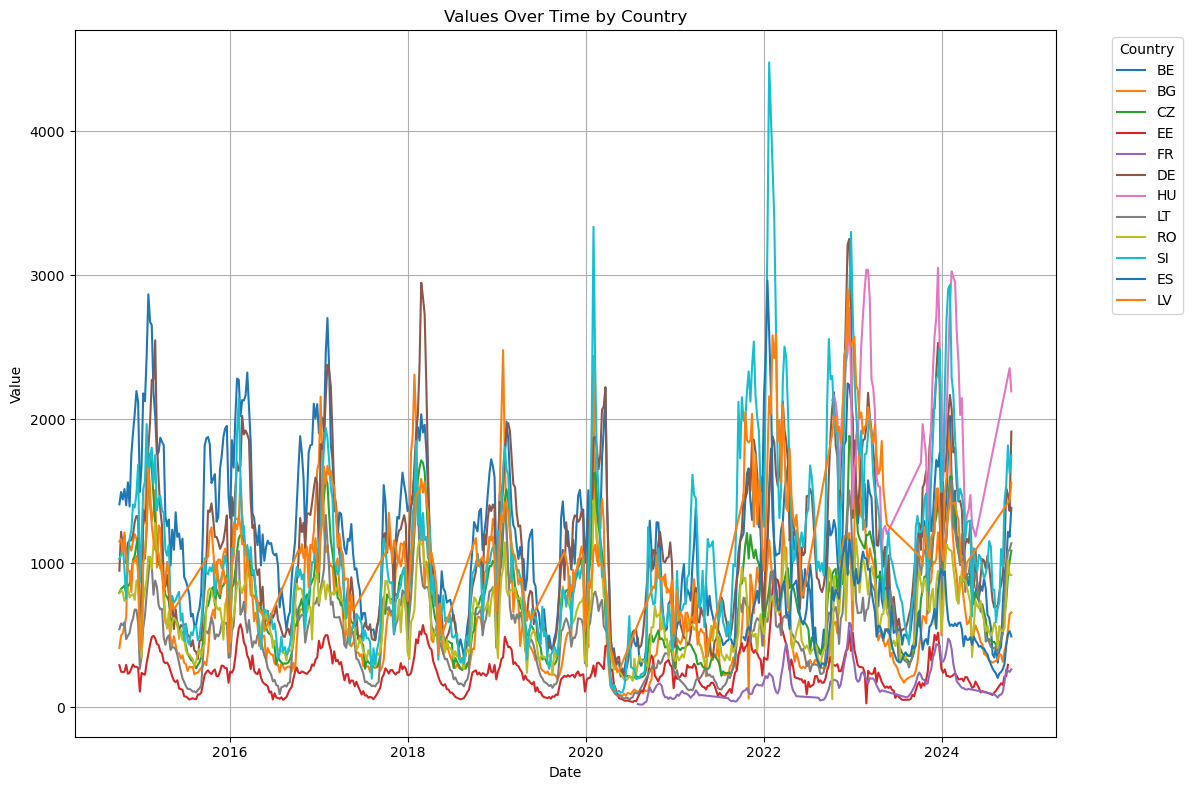

In [58]:
# Plot data for each country
plt.figure(figsize=(12, 8))
for country in countries_ari:
    country_data = ari[ari['value']<6000]
    country_data = country_data[country_data['location'] == country]
    plt.plot(country_data['truth_date'], country_data['value'], label=country)

# Customize the plot
plt.title('Values Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

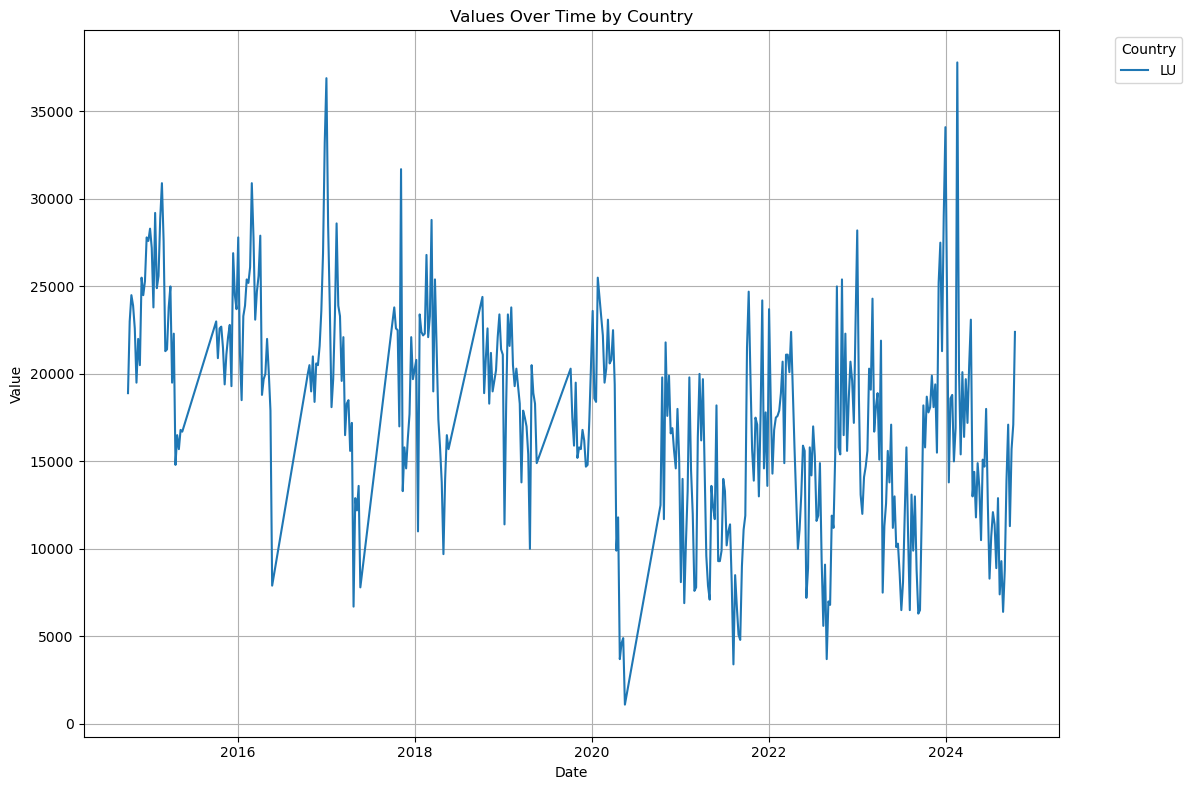

In [59]:
# Plot data for each country
plt.figure(figsize=(12, 8))
for country in countries_ari2:
    country_data = ari[ari['location'] == country]
    plt.plot(country_data['truth_date'], country_data['value'], label=country)

# Customize the plot
plt.title('Values Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [51]:
ari[ari['value']>50000]

,location,truth_date,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min
2826,LV,2024-05-19,2024-W20,100000.0,69.089844,21.149286,8.899286
2827,LV,2024-05-12,2024-W19,100000.0,71.712082,10.342143,4.570714
2828,LV,2024-05-05,2024-W18,100000.0,66.323112,17.177856,8.099286
2829,LV,2024-04-28,2024-W17,100000.0,78.775703,12.949286,2.792143
2830,LV,2024-04-21,2024-W16,100000.0,77.385170,6.335000,0.120714


In [64]:
country_names_ili = [
    "AT","BE","CZ","DK",
    "EE","FR","GR","HR",
    "HU","IE","LT","LV",
    "NL","NO","PL","RO",
    "SI"
]
country_ili_2 = ['LU','MT']

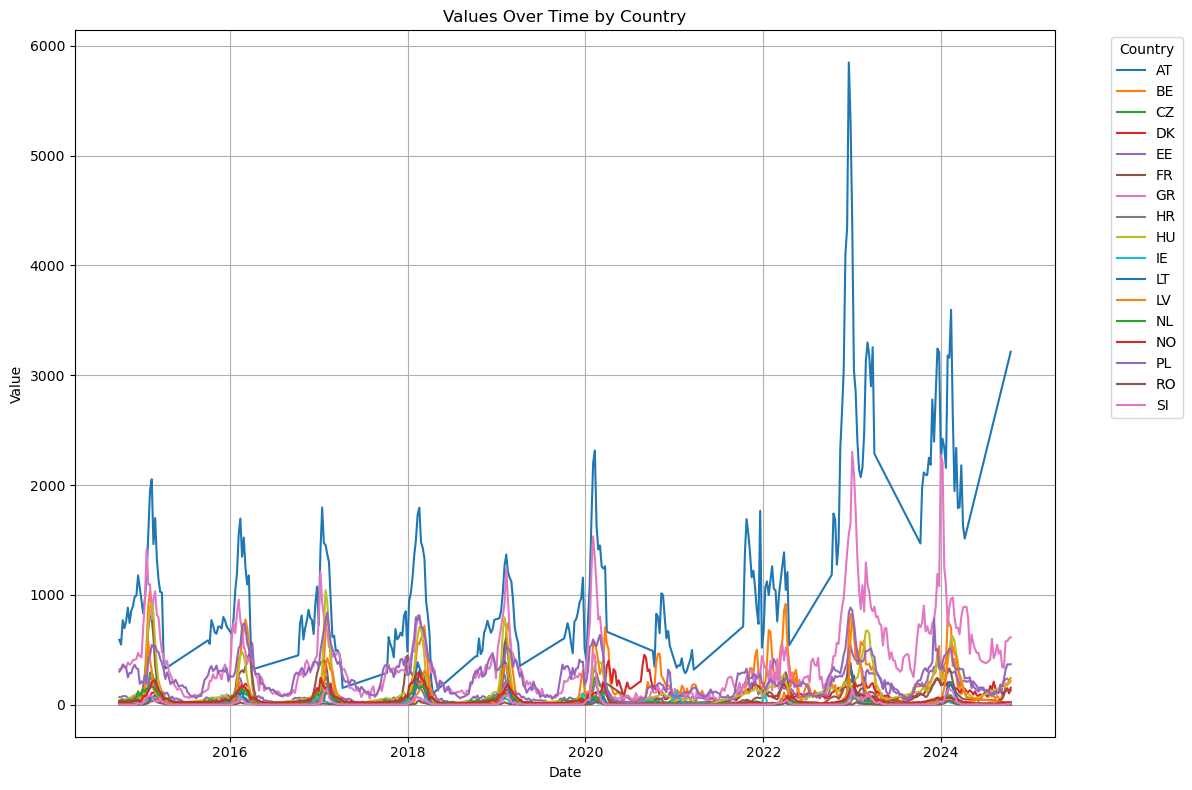

In [65]:
# Plot data for each country
plt.figure(figsize=(12, 8))
for country in country_names_ili:
    country_data = ili[ili['value']<50000]
    country_data = country_data[country_data['location'] == country]
    plt.plot(country_data['truth_date'], country_data['value'], label=country)

# Customize the plot
plt.title('Values Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

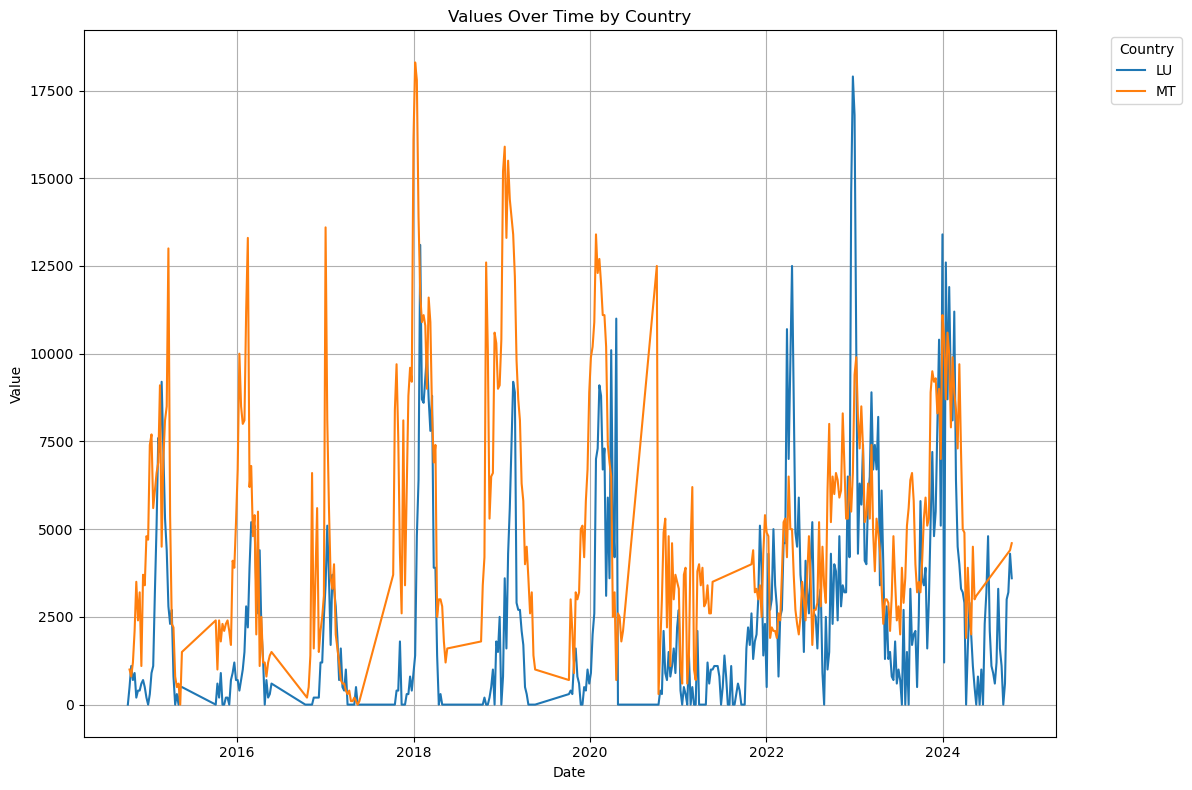

In [66]:
# Plot data for each country
plt.figure(figsize=(12, 8))
for country in country_ili_2:
    country_data = ili[ili['location'] == country]
    plt.plot(country_data['truth_date'], country_data['value'], label=country)

# Customize the plot
plt.title('Values Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [68]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(ili['value'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.854824
p-value: 0.000000


In [69]:
adf_test_ari = adfuller(ari['value'])
# Output the results
print('ADF Statistic: %f' % adf_test_ari[0])
print('p-value: %f' % adf_test_ari[1])

ADF Statistic: -4.264158
p-value: 0.000512
